# Data Science Study Group Project: Neutrino type and background classification
# Data Handling Tutorial 

## Project Overview
I will assume everybody here is roughly familiar with physics of neutrinos and Water Cherenkov detectors.
In this project we will tackle the task of classification of neutrino type ($\nu_e$ or $\nu_\mu$) or rather the charged leptons resulting from the nuclear scatter ($e$ and  $\mu$) as well as an irreducible background from neutral current $\gamma$ production. The dataset comes from simulated Water Cherenkov detector called NuPRISM. NuPRISM is a proposed 'intermediate' detector for the Hyper-Kamiokande project. The detector has a cylindrical geometry and can be lowered and raised in a shaft to sample different energy distribution of incoming neutrinos! ![NUPRISM](img/NUPRISM_diag.png)

The cylinder wall or 'barrel' and end-caps are lined with 'multi-PMT' or 'mPMT' modules arranged in a rectangular grid. Each mPMT is a dome with 19 PMTs arranged in two rings and one at the center:![mPMT](img/mPMT.png)

Here is an event display where the barrel was 'unrolled':
![eventdisp](img/ev_disp.png) - you can clearly see a Cherenkov ring appearing
The 'brightness' corresponds to charge collected by each PMT. Each PMT also tells us the arrival time of the signal.

In this first tutorial we will take a look at the data and how to organize streaming it in batches so that we can feed it to our CNN model

# Set up on cedar.computecanada.ca
We will be working on cedar - a Compute Canada cluster located at SFU.
We will use a container prepared with all the software we might need - and that will also enable us to use GPUs later on.
Here are instructions on how to get started. The istructions below should work for Mac, linux, and Windows 10 Windows Linux Subsystem (Ubuntu bash)

1. If you don't have a github account [MAKE ONE NOW](https://github.com/join)
1. If you don't have a ssh keys from cedar linked to the github account make them now:
   1. If you have no ~/.ssh directory or there is no id_rsa.pub file in that directory type: `ssh -t rsa -b 4096` - and press `Enter` for all prompts
   1. do `cat ~/.ssh/id_rsa.pub` and copy the output to clipboard
   1. on github website click on your avatar in upper right corner, chooose 'Settings'
   1. From menu on the left click on 'SSH and GPG keys'
   1. Click on 'New SSH key' on top right
   1. Paste entire clipboard into the 'Key' field; Name it something snsible e.g. 'cedar'
   
1. First log in to cedar and go to a directory where you can submit jobs from e.g. your /project space then clone the repository where this code lives:  
`git clone git@github.com:triumf-data-science-study-group/NUPRISM-CNN.git`
1. cd inside. There are a few scripts in the repository: `jupyter_job.sh`, `enter_container.sh` and `start_jupyternotebook.sh` 1. these in order are:
   1. SLURM job submission script
   1. script that launches a container
   1. script that launches a jupyter notebook within a container
1. We will be using container software called [singularity](https://www.sylabs.io/). Singularity can run docker containers but is preferred on HPC clusters due to security concerns.
1. The Docker container is based on Nvidia GPU Cloud ([NGC](https://docs.nvidia.com/deeplearning/frameworks/pytorch-release-notes/rel_19-04.html#rel_19-04)) container. The Dockerfile with the recipe is [here](https://github.com/triumfmlutils/Container_Base_ML) and image is hosted on docker hub [here](https://cloud.docker.com/u/triumfmlutils/repository/docker/triumfmlutils/baseml) - you are welcome to pull/extend, but to make things simpler I pulled it onto cedar for you already.
1. Go ahead and examine the scripts...
1. Ok let's submit a job that will launch a jupyter server for you:  
`sbatch ./jupyter_job.sh`
NOTE: if you have multiple roles/projects you will need to specifiy the 'account' under which to submit the job. Generally don't use a project allocation account - that would deplete the allocation. Instead use the 'default' account - this will usually be `def-your-PI-last-name` for example: `sbatch --account=def-doe ./jupyter_job.sh`
1. Hopefully fairly quickly you will get a job running - to sheck if the job is running type:  
`squeue -u ${USER}`
1. You should see something resempling this:  
`   JOBID     USER      ACCOUNT           NAME  ST START_TIME        TIME_LEFT NODES CPUS       GRES MIN_MEM NODELIST (REASON)              21345415 wfedorko def-tafirout       notebook   R 2019-05-22T02:07    4:19:09     1    4     (null)  16000M cdr693 (None) `
1. The `ST`atus column `R` means job is now running `PD` means its pending in the queue.
1. Once the job is running do `ls -rt1` and last file should be something like `log-jupyter-wfedorko-21345415.txt` - except with your userid and job number. Go ahead and less that file. If you have `sshuttle` on a linux machine or a Mac you can use the printed instructions and connect to a notebook. `sshuttle` will not work on Windows 10 Ubuntu bash shell. On all systems you can follow these intructions to open an ssh tunnel and bring up jupyter notebook:
   1. In the log file jupyter told us to connect to the host at a specific port. e.g. in my logfile I see a line toward the end telling me to paste this into my browser: `http://cdr693.int.cedar.computecanada.ca:8888/?token=alotofhexdigitswithtokennumber` - but we can not 'see' the compute node `cdr693` from 'outside' cedar. So let's set up an ssh tunnel via cedar. In this case I did this in a separate shell (on my laptop):  
   `ssh -L 8888:cdr693.int.cedar.computecanada.ca:8888 mycomputecanadauser@cedar.computecanada.ca -N -f`; Then in my browser I paste what jupyter told me to - but I replace the `cdr...canada.ca` with `localhost` - in this case:  
   `http://localhost:8888/?token=alotofhexdigitswithtokennumber` - you shoud get a jupyter 'tree' window and be able to re-open this notebok under `Data Handling Tutorial.ipynb`



Ok! now that you are back lets see if we can see the dataset:

In [1]:
!ls /scratch/wfedorko/TRIUMF_DS_NUPRISM/merged_IWCDmPMT_varyE.h5 -lh

-rw-rw-r-- 1 wfedorko wfedorko 82G May 22 17:15 /scratch/wfedorko/TRIUMF_DS_NUPRISM/merged_IWCDmPMT_varyE.h5


Let's quickly look what's inside... - import h5py, numpy etc and open for reading

In [2]:
import numpy as np
import os, time
import h5py

In [3]:
f=h5py.File("/scratch/wfedorko/TRIUMF_DS_NUPRISM/merged_IWCDmPMT_varyE.h5","r")

`keys()` will give us all the hdf5 datasets stored in the file

In [4]:
f.keys()

<KeysViewHDF5 ['event_data', 'labels']>

Let's look at the shapes of the data:

In [5]:
f['labels'].shape

(900000,)

In [6]:
f['event_data'].shape

(900000, 16, 40, 38)

We have 900k simulated scattering events here! labels are 0, 1, 2 for $\gamma$,$e$ and $\mu$ respectively. The 'event_data' contains only the barrel portion of the tank which has been 'unrolled'. The first dimension (900k) enumerates over the events, the second two dimensions (16,40) enumerate over the row and column in the module 'grid'. Finally last two dimensions enumerate over the PMT within the module (again there are 19 in each mPMT module) first 19 entries correspond to charge collected on a given PMT and last 19 correspond to the time.



## Dataset object

Let's import and create a Dataset object - you are welcome to look at the [source](http://localhost:8888/edit/io_utils/data_handling.py)

In [7]:
from io_utils.data_handling import WCH5Dataset

The class derives from the torch Dataset object. The two heavy lifters are the __init__ function and __getitem__ function.
Let's look at what init does:  
       
       `f=h5py.File(path,'r')
        hdf5_event_data = f["event_data"]
        hdf5_labels=f["labels"]

        assert hdf5_event_data.shape[0] == hdf5_labels.shape[0]

        event_data_shape = hdf5_event_data.shape
        event_data_offset = hdf5_event_data.id.get_offset()
        event_data_dtype = hdf5_event_data.dtype
        
        labels_shape = hdf5_labels.shape
        labels_offset = hdf5_labels.id.get_offset()
        labels_dtype = hdf5_labels.dtype`  
-here we opened the file and got the offsets, shapes, and data types of the datasets. Why are we doing this? This is because the hdf5 file is uncompressed and the datasets within are contiguous - this allows us to do memory mapping of the file. This is important with large datasets like this - where we are most like not going to be able to load everything into memory. Withh memory map we can only load what we need, when we need it


The memory map itself  

        `self.event_data = np.memmap(path, mode='r', shape=event_data_shape, offset=event_data_offset, dtype=event_data_dtype)`
For the labels - we just load them into memory bu constructing a numpy array - this should be no problem even for very large datasets  

        `self.labels = np.array(hdf5_labels)`

The rest of __init__ function computes indices for training, validation and testing sets, based on a random (but consistent) shuffle of events - this will be useful later when trainnig our model. We also provide a facility to only use a subset of the dataset.

Finally we have the __getitem__ method - this provides functionality for the subscript [] operator. Only here we actually load the event_data that was requested:  

            `return np.array(self.event_data[index,:]),  self.labels[index]`
-we return a tuple with two elements - first is the event 'image' and second is the label. If you look at the code you will notice that there is also a provision for providing a transform (which will not do anything atm). This is very useful if you want to do data augmentation on-the-fly. E.g. we could flip the images to 'populate' the dataset to reflect the variability we expect in the dataset we will want to apply the model.


finally we need the len method - this just needs to return how many exmples we have in the dataset

Ok let's instantiate the dataset and ask it for a few examples:

In [8]:
dset=WCH5Dataset("/scratch/wfedorko/TRIUMF_DS_NUPRISM/merged_IWCDmPMT_varyE.h5",val_split=0.1,test_split=0.1)

In [9]:
len(dset)

900000

Let's import matplotlib and tell it to plot inline in the jupyter notebook

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline

Let's get some random event and label:

In [11]:
event, label=dset[800001]

We are going to plot only the PMT charge for the 'center' PMT in mPMT modules - i believe this is at channel 18

class is 0.0


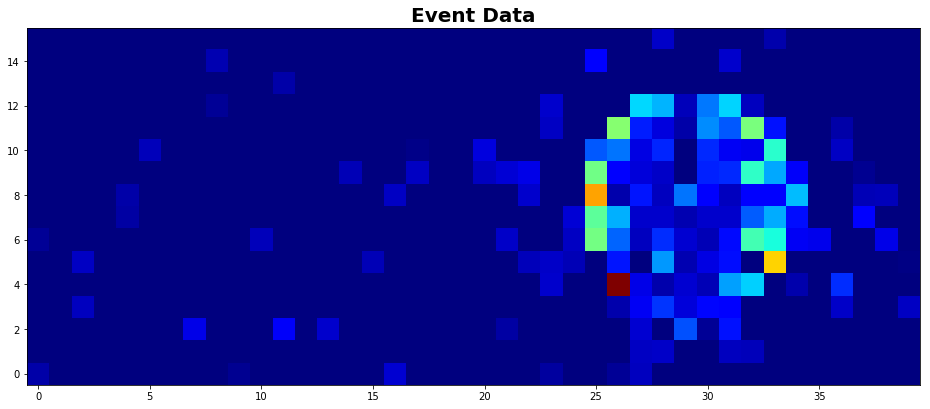

In [12]:
fig, ax = plt.subplots(figsize=(16,8),facecolor='w')
plt.imshow(event[:,:,18],cmap='jet',origin='lower')
ax.set_title('Event Data',fontsize=20,fontweight='bold')
print('class is {}'.format(label))
plt.show()

## DataLoader objects and streaming the data

Now lets actually create DataLoader objects - one for each training, validation and testing set - but each DataLoader uses the same dataset -that way we keep only one open file (this is the 'standard' pytorch way)

In [13]:
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
train_iter=DataLoader(dset,batch_size=64,shuffle=False,sampler=SubsetRandomSampler(dset.train_indices),num_workers=4)
val_iter=DataLoader(dset,batch_size=64,shuffle=False,sampler=SubsetRandomSampler(dset.val_indices),num_workers=4)
test_iter=DataLoader(dset,batch_size=64,shuffle=False,sampler=SubsetRandomSampler(dset.test_indices),num_workers=4)

You see the parameters - like batch_size and sampler - the sampler uses the indices we computed for the training, validation and testing set - if you use a sampler shuffle has to be False. On each iteration the DataLoader object will ask the dataset for a bunch of indices (calling the __getitem__ function we coded earlier) and then collate the data into a batch tensor. The collating can also be customized by providing collate_fn - but for now we will leave it with a default behavior. Did you notice the `num_workers` argument? if >0 this will enable multiprocessing - several processes will be reading examples (if supplied applying the augmentation transformation) and putting the data on queue that would be than 'consumed' by your training/evaluation process. We requested 4 CPUs for the job so we will use that. We are beating on the same storage with all threads - so if we aren't doing much preprocessing it doesn't make sense to make this too high...

Here is how you would iterate over several batches:

In [14]:
def loop_over_set(loader,loop_limit=3):

    # Let's measure time that takes in each loop
    trecord = np.zeros([loop_limit],dtype=np.float32)
    t = time.time()
    for iteration, batch in enumerate(loader):

        data,label = batch

        # Print out some content info
        print('Iteration',iteration,'... time:',time.time()-t,'[s]')
        print('    Labels:',label)

        trecord[iteration] = time.time() - t
        t = time.time()

        # break when reaching the loop limit
        if (iteration+1) == loop_limit:
            break
    return trecord

Convince yourself that the `data` and `label` are already tensors - which we could plug into our (future) model. Now let's iterate over first 40 batches

In [15]:
loop_over_set(train_iter, 40)

Iteration 0 ... time: 13.395081520080566 [s]
    Labels: tensor([0., 1., 0., 0., 0., 2., 0., 0., 1., 1., 2., 2., 1., 2., 1., 1., 1., 0.,
        2., 0., 1., 0., 2., 0., 2., 0., 0., 0., 2., 0., 1., 2., 2., 1., 2., 2.,
        2., 2., 0., 1., 2., 2., 2., 1., 2., 0., 1., 1., 0., 1., 2., 1., 2., 2.,
        0., 2., 1., 2., 2., 1., 2., 2., 0., 0.])
Iteration 1 ... time: 0.1952211856842041 [s]
    Labels: tensor([1., 1., 0., 1., 2., 2., 1., 2., 0., 0., 0., 0., 1., 2., 1., 1., 0., 1.,
        1., 1., 0., 0., 0., 0., 0., 2., 0., 2., 0., 2., 2., 0., 0., 1., 2., 0.,
        1., 1., 2., 1., 1., 2., 2., 1., 1., 1., 2., 0., 0., 1., 0., 1., 0., 1.,
        0., 2., 1., 2., 0., 0., 1., 2., 2., 0.])
Iteration 2 ... time: 0.0013921260833740234 [s]
    Labels: tensor([2., 1., 0., 2., 1., 1., 0., 2., 0., 1., 1., 0., 2., 0., 1., 1., 1., 0.,
        0., 2., 2., 1., 0., 2., 0., 1., 0., 1., 0., 1., 1., 2., 2., 1., 1., 2.,
        1., 1., 0., 0., 1., 1., 2., 1., 1., 0., 2., 0., 1., 2., 0., 2., 2., 0.,
        

Iteration 24 ... time: 10.637712240219116 [s]
    Labels: tensor([0., 2., 0., 0., 2., 0., 0., 1., 2., 1., 0., 1., 2., 0., 0., 1., 2., 2.,
        1., 0., 0., 0., 0., 1., 0., 0., 1., 0., 2., 0., 2., 1., 0., 2., 1., 0.,
        2., 2., 2., 1., 1., 2., 0., 0., 1., 1., 1., 2., 1., 2., 2., 1., 2., 1.,
        0., 1., 0., 1., 0., 0., 2., 1., 1., 1.])
Iteration 25 ... time: 2.0094218254089355 [s]
    Labels: tensor([2., 2., 2., 0., 2., 0., 1., 1., 0., 1., 1., 2., 2., 0., 2., 1., 1., 2.,
        1., 2., 0., 0., 1., 1., 1., 1., 2., 2., 0., 1., 0., 2., 0., 0., 0., 2.,
        0., 2., 2., 0., 0., 2., 2., 0., 0., 0., 0., 2., 2., 0., 2., 2., 0., 0.,
        0., 0., 2., 0., 0., 2., 2., 2., 0., 0.])
Iteration 26 ... time: 0.001748800277709961 [s]
    Labels: tensor([1., 1., 0., 2., 1., 1., 0., 2., 0., 1., 0., 1., 0., 0., 0., 2., 0., 0.,
        2., 2., 1., 0., 2., 1., 0., 1., 1., 1., 2., 0., 2., 1., 1., 0., 0., 1.,
        0., 0., 1., 2., 1., 0., 1., 2., 0., 1., 0., 0., 2., 2., 2., 1., 1., 2.,
      

array([1.34990568e+01, 1.98249817e-01, 4.16111946e-03, 4.15825844e-03,
       1.41849785e+01, 1.95436168e+00, 5.96785545e-03, 5.82909584e-03,
       1.13512354e+01, 1.92124510e+00, 4.17447090e-03, 3.78942490e-03,
       8.56816006e+00, 4.60999870e+00, 4.51564789e-03, 4.34207916e-03,
       7.56507301e+00, 4.99260283e+00, 4.24933434e-03, 5.04899025e-03,
       8.09719849e+00, 3.27507114e+00, 5.53560257e-03, 5.24926186e-03,
       1.06406584e+01, 2.01308632e+00, 5.06830215e-03, 5.02443314e-03,
       9.58063221e+00, 7.71890545e+00, 5.58161736e-03, 5.45787811e-03,
       6.09541368e+00, 4.11417770e+00, 5.22494316e-03, 5.37395477e-03,
       4.40862370e+00, 7.77126789e+00, 5.00988960e-03, 4.82296944e-03],
      dtype=float32)

OMG that was slow... and we aren't even oing anything with the data- do you notice that roughly every 4th iteration the time it takes to give a batch is huge? Why?

The batch manager (`SLURM` on Compute Canada) gives us a location of fast storage we are supposed to use for accessing repeatedly a dataset with low latency. Any system ought to have a local fast scratch for purposes like this. Different batch managers may or may not give you a specific location for your data

In [16]:
print(os.environ['SLURM_TMPDIR'])

/localscratch/wfedorko.21363245.0


Let's copy the dataset there and repeat the exercise

In [18]:
t=time.time()
!cp /scratch/wfedorko/TRIUMF_DS_NUPRISM/merged_IWCDmPMT_varyE.h5 ${SLURM_TMPDIR}/ -v
tdiff=time.time()-t
print("that took {} seconds".format(tdiff))

'/scratch/wfedorko/TRIUMF_DS_NUPRISM/merged_IWCDmPMT_varyE.h5' -> '/localscratch/wfedorko.21363245.0/merged_IWCDmPMT_varyE.h5'
that took 213.89068460464478 seconds


In [19]:
dset=WCH5Dataset(os.environ['SLURM_TMPDIR']+"/merged_IWCDmPMT_varyE.h5",val_split=0.1,test_split=0.1)

In [20]:
train_iter=DataLoader(dset,batch_size=64,shuffle=False,sampler=SubsetRandomSampler(dset.train_indices),num_workers=4)
val_iter=DataLoader(dset,batch_size=64,shuffle=False,sampler=SubsetRandomSampler(dset.val_indices),num_workers=4)
test_iter=DataLoader(dset,batch_size=64,shuffle=False,sampler=SubsetRandomSampler(dset.test_indices),num_workers=4)

In [21]:
loop_over_set(train_iter, 40)

Iteration 0 ... time: 0.39338254928588867 [s]
    Labels: tensor([1., 1., 1., 2., 2., 1., 0., 1., 1., 0., 2., 0., 0., 1., 0., 0., 2., 1.,
        0., 2., 1., 2., 0., 2., 0., 1., 0., 0., 1., 0., 0., 2., 0., 1., 2., 0.,
        2., 1., 2., 0., 2., 2., 1., 0., 1., 0., 0., 0., 2., 1., 1., 1., 1., 0.,
        1., 0., 1., 2., 2., 0., 2., 2., 0., 1.])
Iteration 1 ... time: 0.006192922592163086 [s]
    Labels: tensor([0., 2., 2., 2., 2., 1., 1., 1., 1., 1., 0., 2., 0., 0., 2., 1., 2., 2.,
        1., 1., 2., 2., 0., 1., 1., 0., 2., 2., 0., 1., 0., 1., 1., 2., 1., 0.,
        2., 0., 0., 1., 2., 2., 0., 0., 0., 0., 2., 1., 2., 2., 2., 0., 1., 1.,
        1., 0., 0., 2., 2., 1., 2., 2., 2., 1.])
Iteration 2 ... time: 0.0015833377838134766 [s]
    Labels: tensor([2., 1., 0., 2., 1., 2., 1., 1., 2., 0., 2., 1., 2., 0., 1., 2., 0., 2.,
        1., 1., 2., 1., 2., 2., 1., 1., 2., 1., 0., 2., 1., 0., 0., 2., 0., 2.,
        0., 1., 0., 0., 1., 0., 0., 2., 2., 1., 0., 2., 2., 1., 1., 1., 0., 1.,
     

Iteration 24 ... time: 0.10514974594116211 [s]
    Labels: tensor([2., 0., 0., 2., 0., 1., 2., 2., 1., 2., 0., 1., 1., 2., 0., 0., 2., 0.,
        2., 0., 0., 0., 1., 2., 1., 2., 2., 1., 1., 1., 2., 0., 2., 1., 0., 2.,
        1., 0., 2., 1., 1., 2., 0., 1., 2., 1., 1., 2., 0., 2., 2., 1., 2., 0.,
        2., 1., 0., 2., 1., 1., 1., 1., 0., 0.])
Iteration 25 ... time: 0.031655311584472656 [s]
    Labels: tensor([2., 2., 1., 1., 2., 0., 0., 0., 0., 2., 2., 1., 2., 0., 1., 0., 2., 2.,
        0., 0., 2., 2., 0., 2., 1., 1., 1., 2., 0., 0., 0., 2., 2., 2., 2., 2.,
        2., 1., 0., 2., 1., 1., 0., 1., 2., 1., 0., 2., 0., 0., 2., 1., 0., 0.,
        1., 0., 1., 2., 1., 2., 1., 2., 0., 0.])
Iteration 26 ... time: 0.0014500617980957031 [s]
    Labels: tensor([2., 2., 0., 2., 0., 0., 2., 2., 0., 2., 1., 2., 1., 1., 2., 2., 0., 0.,
        0., 0., 1., 1., 1., 0., 2., 2., 2., 0., 1., 1., 0., 1., 1., 0., 1., 2.,
        2., 2., 1., 1., 2., 1., 1., 2., 0., 0., 1., 2., 0., 0., 1., 0., 1., 2.,
  

array([0.3971002 , 0.00924706, 0.00454521, 0.00485611, 0.1251483 ,
       0.00410581, 0.00636053, 0.00424099, 0.11881042, 0.0102489 ,
       0.00733089, 0.0042491 , 0.12887645, 0.02322483, 0.00766492,
       0.00466919, 0.11041856, 0.03000998, 0.00548697, 0.00416946,
       0.10714102, 0.03271365, 0.00690269, 0.00406194, 0.10816264,
       0.03446817, 0.00417995, 0.0039587 , 0.10596228, 0.04212618,
       0.00401545, 0.00505567, 0.10406089, 0.03024292, 0.00436854,
       0.00369549, 0.10205698, 0.03704715, 0.00408864, 0.0042901 ],
      dtype=float32)

Ok - way faster - even though it took a long time initially to copy the dataset - it's going to remove the bottleneck of data access during training - especially that we are going to be looping over the dataset many times

Now try to get familiar with the data. Plot different event in different classes. Energy sums and histograms. Time histograms etc. Can you 'spot' the differences between classes 'by eye'.

## And remember to clean up!!!

In [22]:
!rm -v ${SLURM_TMPDIR}/*

removed '/localscratch/wfedorko.21363245.0/merged_IWCDmPMT_varyE.h5'
removed '/localscratch/wfedorko.21363245.0/test'
